In [85]:
#Cargar la biblioteca pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd
import math

In [86]:
#lA FUNCION HEADER ES PARA LEER LOS PRIMEROS DOS RENGLOPNES COMO EL TITULO DE LA COLUMNA
df0 = pd.read_excel('meteo-vid-2018.xlsx')
df5 = pd.read_excel('flujos-vid-2018.xlsx')
#df0 = pd.read_excel('meteo.xlsx',engine='python')
#pd.options.display.max_rows = 20000
#pd.options.display.max_columns = 100

In [87]:
df2=pd.DataFrame([])

In [88]:
df2["MES"] = df0["Date"].dt.month
df2["Day"] = df0["Date"].dt.day
df2["Velviento"] = df0["WS_ms_S_WVT"]
df2["Temp"] = df0["AirTC_Avg"]
df2["RH"] = df0["RH"]
df2["RS"] = df0["Rs_net_Avg"]

In [89]:
df3 = pd.DataFrame([])
dfaux = pd.DataFrame([])

In [90]:
df3["RHmean"] = df2.groupby(["MES"])["RH"].transform("mean")
df3["RHmin"] = df2.groupby(["MES"])["RH"].transform("max")
df3["RHmax"] = df2.groupby(["MES"])["RH"].transform("min")
df3["Tempmean"] = df2.groupby(["MES"])["Temp"].transform("mean")
df3["Teammax"] = df2.groupby(["MES"])["Temp"].transform("max")
df3["Teammin"] = df2.groupby(["MES"])["Temp"].transform("min")
df3["RS"] = df2.groupby(["MES"])["RS"].transform("mean")
df3["Velviento"] = df2.groupby(["MES"])["Velviento"].transform("mean")
df3["MES"] = df2["MES"]
df3["Dia"] = df2["Day"]

In [91]:
dfaux = df3

In [92]:
df3=df3.drop_duplicates()

<Figure size 864x576 with 0 Axes>

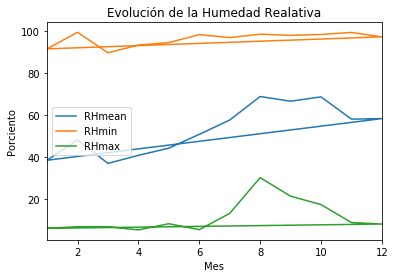

In [93]:
plt.figure(figsize=(12,8))
df3.plot(x="MES", y=["RHmean" , "RHmin" , "RHmax"])
plt.title("Evolución de la Humedad Realativa")
plt.ylabel("Porciento")
plt.xlabel("Mes")
#plt.figure(figsize=(12,8))
plt.show()

<Figure size 864x576 with 0 Axes>

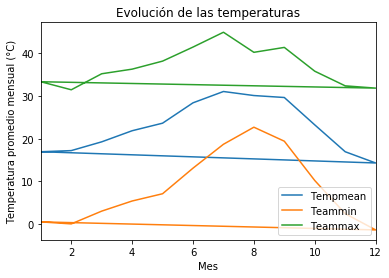

In [94]:
plt.figure(figsize=(12,8))
df3.plot(x="MES", y=["Tempmean" , "Teammin" , "Teammax"])
plt.title("Evolución de las temperaturas")
plt.ylabel("Temperatura promedio mensual (°C)")
plt.xlabel("Mes")
plt.show()

<Figure size 864x576 with 0 Axes>

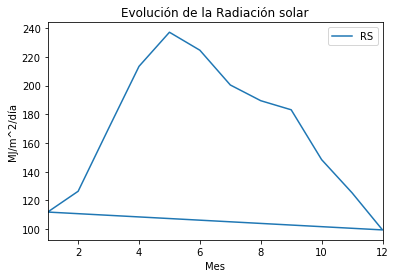

In [95]:
plt.figure(figsize=(12,8))
df3.plot(x="MES", y=["RS"])
plt.title("Evolución de la Radiación solar")
plt.ylabel("MJ/m^2/día")
plt.xlabel("Mes")
plt.show()

In [96]:
# ET0 = (0.0252T + 0.078)Rs , Jansen & Haise (1963)
#df2
df4 = pd.DataFrame([])
df4["JanyHai"] = 0.0252*df2["RS"]*df2["Temp"] + 0.078*df2["RS"]

In [97]:
#Ec. 31, Valiantzas 1 (2012):  𝜑 es la latitud en radianes
lati = 28.918611
df4["Var1"] = 0.0393*df2["RS"]*(dfaux["Tempmean"] + 9.5)**.5 - 0.19*(df2["RS"]**6)**0.1*((math.pi/180.)*(lati))**0.15 + 0.0061*(dfaux["Tempmean"] + 20)*(1.12*dfaux["Tempmean"] - dfaux["Teammin"]-2)**0.7

In [98]:
l=len(df0)
val2=[]

for i in range (0,l):
    
    RS=dfaux.RS[i]
    mean=dfaux.Tempmean[i]
    lati=28.918611
    mn=dfaux.Teammin[i]
    z=101
    u=df0.WS_ms_S_WVT[i]
    a=df0.albedo_Avg[i]
    RH=df0.RH[i]
     
    
    if i==0:
        j=dfaux.Dia[0]
    elif dfaux.Dia[i] != dfaux.Dia[i-1]:
        j=j+1
    elif dfaux.Dia[i] == dfaux.Dia[i-1]:
        j=j
    
    
    d=1+0.033*math.cos(2*j*math.pi/365)
    
    g=0.409*math.sin(2*j*math.pi/365 - 1.39)
    
    w=math.acos(-math.tan(lati*math.pi/180) * math.tan(g) )
    

    Ra = (24*60/math.pi)*d*( w*math.sin(g)*math.sin(lati*math.pi/180) + math.cos(g)*math.cos(lati*math.pi/180)*math.sin(w))
    
    h= 0.051*(1-a)*RS*(mean+9.5)**0.5 - 2.4*(RS/Ra)**2 + 0.048*(mean+20)*(1- RH/100)*(0.5+0.536*u) + 0.00012*z
    
    val2.append(h)
df4["Var4"] = val2

In [99]:
#df4["Var2"] = 0.0393*df2["RS"]*(dfaux["Tempmean"] + 9.5)**.5 - 0.19*(df2["RS"]**6)**0.1*((math.pi/180.)*(lati))**0.15 + 0.078*(dfaux["Tempmean"]+20)*(1-df2["RH"]/100.)
#df4["d"] = 0.033*math.cos(((2*3.14)/365.)*df2["Day"]) + 1
#df4["ws"] = math.acos(-math.tan(df2["Day"])*math.tan(df4["d"]))*(3.14/180.)
#df4["sigma"] = 0.409*math.sin((2*3.14/365)*df2["Day"] - 1.39)*(3.14/180.)
#df4["Prueba"]=math.cos(df4["Var2"])
#df4["Ra"] = (24*60/3.14)*0.0820*df4["d"]*(df4["ws"]*math.sin(28.55*(3.14/180.))*math.sin(df4["sigma"])+math.cos(28.55*(3.14/180.))*math.cos(df4["sigma"])*math.sin(f4["ws"]))
#df4["Var2"] = 0.051*(1 - df0["albedo_Avg"])*df2["RS"]*(dfaux["Tempmean"] + 9.5)**.5 - 2.4*(df2["RS"]/df4["Ra"])**2
#+ 0.048*(dfaux["Tempmean"] + 20)*(1-df2["RH"]/100.)*(.5 + 0.536*df0["WS_ms_S_WVT"]) + 0.00012*(101)

In [100]:
df4["Mes"] = df2["MES"]

In [101]:
df4.head()

,JanyHai,Var1,Var4,Mes
0,27.990573,7.409444,31.362990,1
1,16.700580,5.012531,31.780606,1
2,0.991553,1.674980,31.328664,1
3,-2.123037,0.623591,35.576110,1
4,-1.856133,0.706836,35.315781,1


In [104]:
df4["JanyHai"]= df4.groupby(["Mes"])["JanyHai"].transform("mean")
df4["Var1"]= df4.groupby(["Mes"])["Var1"].transform("mean")
df4["Var4"]= df4.groupby(["Mes"])["Var4"].transform("mean")

In [105]:
df4=df4.drop_duplicates()

In [112]:
df4

,JanyHai,Var1,Var4,Mes
0,77.553930,22.000811,43.165927,1
1214,81.500686,24.969543,50.449047,2
2558,126.578692,34.694631,67.057178,3
4046,176.290800,45.482331,86.068343,4
5486,204.880366,52.006233,96.785325,5
6974,212.760134,52.987382,99.099546,6
8414,196.192421,48.962891,78.859969,7
9902,179.728331,45.273595,84.900674,8
11390,174.711811,43.777461,87.684736,9
12830,121.341812,32.452692,70.496390,10


In [107]:
#df5 = pd.read_excel('flujos-vid-2018.xlsx')
df6 = pd.DataFrame([])
df6["RnG"] = df5["Rg_f"]
df6["ET"] = df5["LE_f"]
df6["H"] = df5["H_f"]
df6["Dia"] = df5["DoY"]
df6["Ano"] = df5["Year"]
df6["Hora"] = df5["Hour"]

In [108]:
df7=pd.DataFrame([])

rng=[]
et=[]
h=[]
dia=[]
ano=[]
hora=[]
for i in range (0,len(df6)):
    if df6.Dia[i]<32:
        rng.append(df6.RnG[i])
        et.append(df6.ET[i])
        h.append(df6.H[i])
        ano.append(df6.Ano[i])
        hora.append(df6.Hora[i])
        dia.append(df6.Dia[i])
        
df7["RnG"] = rng
df7["ET"] = et
df7["H"] = h
df7["Hora"] = hora

In [109]:
df7["RnG"] = df6.groupby(["Hora"])["RnG"].transform("mean")
df7["ET"] = df6.groupby(["Hora"])["ET"].transform("mean")
df7["H"] = df6.groupby(["Hora"])["H"].transform("mean")

In [110]:
df7=df7.drop_duplicates()

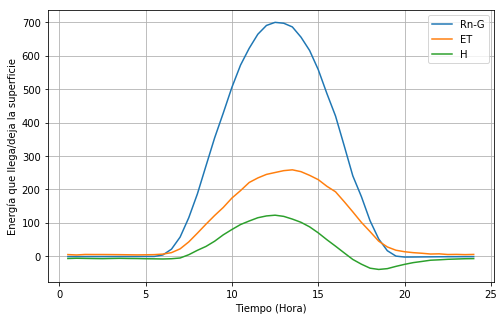

In [111]:
plt.figure(1, figsize=(8, 5))

plt.plot(df7.Hora, df7.RnG)
plt.plot(df7.Hora, df7.ET)
plt.plot(df7.Hora, df7.H)

plt.ylabel("Energía que llega/deja la superficie")
plt.xlabel("Tiempo (Hora)")
plt.gca().legend(('Rn-G','ET',"H"))
plt.grid(True)
plt.show()